In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_an = pd.read_csv('./data/만족도모델_입력데이터_기업명.csv', encoding='cp949')

input_an

,기업명,납기준수율,평균 납기지체일수,하자처리 건수,품질 만족도,가격 만족도,서비스 만족도,사후 만족도,납품품목비율,하자처리 기간,부정당업자 제재기간,거래정지 기간
0,기업 A,75,10,5,4,4,3,3,76,9,30,45
1,기업 B,90,4,1,6,5,6,5,90,3,3,6
2,기업 C,35,20,8,1,1,0,1,43,15,120,130
3,기업 D,82,7,2,5,5,4,4,87,6,15,30
4,기업 E,45,17,7,2,3,2,2,50,12,90,80


In [3]:
# 평가항목 정보
dline_rate = {'항목' : '납기준수율', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : False, '배점' : 13}
dline_delay = {'항목' : '평균 납기지체일수', '최솟값' : 0, '최댓값' : 30, '망대 여부' : False, '퍼지 여부' : False, '배점' : 12}
flaw = {'항목' : '하자처리 건수', '최솟값' : 0, '최댓값' : 8, '망대 여부' : False, '퍼지 여부' : False, '배점' : 9}
quality = {'항목' : '품질 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 12}
price = {'항목' : '가격 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
service = {'항목' : '서비스 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
post = {'항목' : '사후 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
item_rate = {'항목' : '납품품목비율', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : False, '배점' : 8}
as_period = {'항목' : '하자처리기간', '최솟값' : 3, '최댓값' : 24, '망대 여부' : False, '퍼지 여부' : False, '배점' : 8}
fraud_penalty  = {'항목' : '부정당업자 제재기간', '최솟값' : 0, '최댓값' : 270, '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}
trade_penalty  = {'항목' : '거래정지 기간', '최솟값' : 0, '최댓값' : 270, '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}

pd.DataFrame([dline_rate, dline_delay, flaw, quality, price, service, post, item_rate, as_period, fraud_penalty, trade_penalty])

,항목,최솟값,최댓값,망대 여부,퍼지 여부,배점
0,납기준수율,0,100,True,False,13
1,평균 납기지체일수,0,30,False,False,12
2,하자처리 건수,0,8,False,False,9
3,품질 만족도,0,100,True,True,12
4,가격 만족도,0,100,True,True,6
5,서비스 만족도,0,100,True,True,6
6,사후 만족도,0,100,True,True,6
7,납품품목비율,0,100,True,False,8
8,하자처리기간,3,24,False,False,8
9,부정당업자 제재기간,0,270,False,False,10


In [4]:
# 사다리꼴 퍼지수 구간
pts_list = []
a = 0; b = 12.5
for _ in range(7):
    pts_list.append((a, b))
    a += 12.5 + 2.08
    b += 2.08 + 12.5
    
pts_list

[(0, 12.5),
 (14.58, 27.08),
 (29.16, 41.66),
 (43.74, 56.239999999999995),
 (58.32, 70.82),
 (72.9, 85.39999999999999),
 (87.48, 99.97999999999999)]

In [5]:
class model():
    def __init__(self):
        # 평가항목별 정보
        self.dline_rate = {'항목' : '납기준수율', '최솟값' : 0, '최댓값' : 100,
                           '망대 여부' : True, '퍼지 여부' : False, '배점' : 13}
        self.dline_delay = {'항목' : '평균 납기지체일수', '최솟값' : 0, '최댓값' : 30,
                            '망대 여부' : False, '퍼지 여부' : False, '배점' : 12}
        self.flaw = {'항목' : '하자처리 건수', '최솟값' : 0, '최댓값' : 8,
                     '망대 여부' : False, '퍼지 여부' : False, '배점' : 9}
        self.quality = {'항목' : '품질 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 12}
        self.price = {'항목' : '가격 만족도', '최솟값' : 0, '최댓값' : 100,
                      '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.service = {'항목' : '서비스 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.post = {'항목' : '사후 만족도', '최솟값' : 0, '최댓값' : 100,
                     '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.item_rate = {'항목' : '납품품목비율', '최솟값' : 0, '최댓값' : 100,
                          '망대 여부' : True, '퍼지 여부' : False, '배점' : 8}
        self.as_period = {'항목' : '하자처리기간', '최솟값' : 3, '최댓값' : 24,
                          '망대 여부' : False, '퍼지 여부' : False, '배점' : 8}
        self.fraud_penalty  = {'항목' : '부정당업자 제재기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}
        self.trade_penalty  = {'항목' : '거래정지 기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}

        # 평가항목 리스트
        self.list = {'납기준수율' : self.dline_rate, '평균 납기지체일수' : self.dline_delay, '하자처리 건수' : self.flaw,
                     '품질 만족도' : self.quality, '가격 만족도' : self.price, '서비스 만족도' : self.service,
                     '사후 만족도' : self.post, '납품품목비율' : self.item_rate, '하자처리 기간' : self.as_period,
                     '부정당업자 제재기간' : self.fraud_penalty, '거래정지 기간' : self.trade_penalty}
        
        # 사다리꼴 퍼지수 피크 구간
        self.pts_list = [(0, 12.5), (14.58, 27.08), (29.16, 41.66), (43.74, 56.24), (58.32, 70.82), (72.9, 85.4), (87.48, 100)]
    
    # 구간 연산 - 뺄셈 함수: intv1 - intv2
    def intv_sub(self, intv1, intv2):
        min_ = intv1[0] - intv2[1]
        max_ = intv1[1] - intv2[0]
        return min_, max_
    
    # 만족도 계산
    def get_fuzzy_score(self, y_i, y_min, y_max, isMangdae, isFuzzy):
        if isMangdae:    # 망대 특성인 경우
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연산를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min])
                y_max = np.array([y_max, y_max])
                y_i = np.array(y_i)
                if np.mean(y_i) < np.mean(y_min):
                    score = (0, 0)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (1, 1)
                else:
                    bunja = self.intv_sub(y_i, y_min)
                    bunmo = self.intv_sub(y_max, y_min)
                    cases = [a/b for a in bunja for b in bunmo]       # 분자/분모의 구간 연산
                    score = (min(cases), max(cases))

                return score

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (score, score)


        else:    # 망소 특성인 경우 -> 1에서 뺀 값을 반환
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연상를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min])
                y_max = np.array([y_max, y_max])
                y_i = np.array(y_i)

                if np.mean(y_i) < np.mean(y_min):
                    score = (1, 1)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (0, 0)
                else:
                    bunja = self.intv_sub(y_i, y_min)
                    bunmo = self.intv_sub(y_max, y_min)
                    cases = [a/b for a in bunja for b in bunmo]        # 분자/분모의 구간 연산
                    score = (1-max(cases), 1-min(cases))

                return score

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (1-score, 1-score)
    
    def get_score(self, data):
        total_score = np.array([0., 0.])
        for key, value in dict(data[1:]).items():   # key : 평가항목명, value : 해당 항목 관측값
            info = self.list[key]                    # 해당 항목 정보
            y_i = value
            y_min = info['최솟값']; y_max = info['최댓값']
            isMangdae = info['망대 여부']; isFuzzy = info['퍼지 여부']
            allot = info['배점']
            if isFuzzy:
                y_i = self.pts_list[y_i]
            
            total_score += np.array(self.get_fuzzy_score(y_i, y_min, y_max, isMangdae, isFuzzy)) * allot
            
        return total_score / 100

In [6]:
# 사다리꼴 그리기
def plot_trape(score, score_with_spread, col):
    plt.plot((score_with_spread[0], score[0]), (0, height), color=col, label=company_name[-1])
    plt.plot((score[0], score[1]), (height, height), color=col)
    plt.plot((score[1], score_with_spread[1]), (height, 0), color=col)

In [7]:
def tuple_to_str(tup):
    return f'({tup[0]:.3f}, {tup[1]:.3f})'

def tuple_to_str2(tup):
    return f'({tup[0]:.3f}, {tup[1]:.3f}, {tup[2]:.3f}, {tup[3]:.3f})'

In [8]:
sat_model = model()

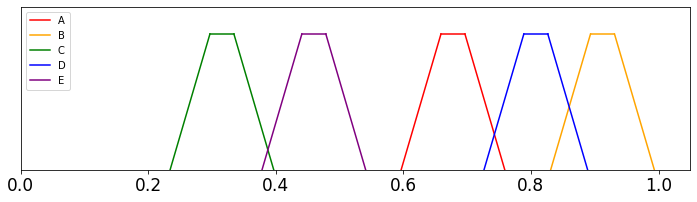

In [9]:
# 결과 확인
scores = []
scores_with_spread = []
company_names = []
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
plt.xlim(0, 1.05)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])


for i in range(len(input_an)):
    data = input_an.iloc[i]
    company_name = data[0]
    score = sat_model.get_score(data)
    score_with_spread = np.clip(score + np.array([-0.0625, 0.0625]), 0, 1)
    
    company_names.append(company_name)
    scores.append(score) 
    scores_with_spread.append(score_with_spread)
    
    plot_trape(score, score_with_spread, cols[i])

plt.legend(loc='upper left')   
plt.show()    

In [10]:
temp = [(scores_with_spread[i][0], scores[i][0], scores[i][1], scores_with_spread[i][1]) for i in range(len(scores))]
pd.DataFrame({'기업명' : company_names,
              '구간만족도' : list(map(tuple_to_str, scores)),
              '퍼지만족도' : list(map(tuple_to_str2, temp))})

,기업명,구간만족도,퍼지만족도
0,기업 A,"(0.659, 0.696)","(0.596, 0.659, 0.696, 0.759)"
1,기업 B,"(0.893, 0.931)","(0.831, 0.893, 0.931, 0.993)"
2,기업 C,"(0.297, 0.334)","(0.234, 0.297, 0.334, 0.397)"
3,기업 D,"(0.789, 0.826)","(0.726, 0.789, 0.826, 0.889)"
4,기업 E,"(0.441, 0.478)","(0.378, 0.441, 0.478, 0.541)"


# 동일기업 존재

In [11]:
df2 = pd.read_csv('./data/만족도모델_입력데이터_동일기업.csv', encoding='cp949')

In [12]:
df2.head()

,기업명,납기준수율,평균 납기지체일수,하자처리 건수,품질 만족도,가격 만족도,서비스 만족도,사후 만족도,납품품목비율,하자처리 기간,부정당업자 제재기간,거래정지 기간
0,기업 A,90,4,1,6,5,6,5,90,3,3,6
1,기업 A,90,4,1,5,5,4,5,90,3,3,6
2,기업 C,35,20,8,1,1,0,1,43,15,120,130
3,기업 D,82,7,2,5,5,4,4,87,6,15,30
4,기업 E,45,17,7,2,3,2,2,50,12,90,80


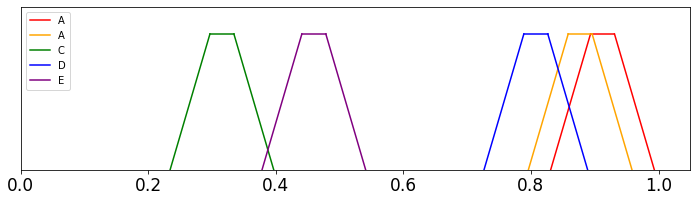

In [13]:
# 결과 확인
scores = []
scores_with_spread = []
company_names = []
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
plt.xlim(0, 1.05)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])


for i in range(len(df2)):
    data = df2.iloc[i]
    company_name = data[0]
    score = sat_model.get_score(data)
    score_with_spread = np.clip(score + np.array([-0.0625, 0.0625]), 0, 1)
    
    company_names.append(company_name)
    scores.append(score) 
    scores_with_spread.append(score_with_spread)
    
    plot_trape(score, score_with_spread, cols[i])

plt.legend(loc='upper left')   
plt.show()    

In [14]:
pre_result = pd.DataFrame({'기업명' : company_names,
                           '만족도_l' : [s[0] for s in scores],
                           '만족도_r' : [s[1] for s in scores],
                           '퍼지만족도_l' : [s[0] for s in scores_with_spread],
                           '퍼지만족도_r' : [s[1] for s in scores_with_spread]}).groupby(by='기업명', as_index=False).mean()
score_tuple = [(pre_result['만족도_l'][i], pre_result['만족도_r'][i]) for i in range(len(pre_result))]
score_sp_tuple = [(pre_result['퍼지만족도_l'][i], pre_result['퍼지만족도_r'][i]) for i in range(len(pre_result))]

temp2 = [(score_sp_tuple[i][0], score_tuple[i][0], score_tuple[i][1], score_sp_tuple[i][1]) for i in range(len(score_tuple))]

result2 = pd.DataFrame({'기업명' : pre_result['기업명'],
                        '구간만족도' : list(map(tuple_to_str, score_tuple)),
                        '퍼지만족도' : list(map(tuple_to_str2, temp2))})

In [15]:
result2

,기업명,구간만족도,퍼지만족도
0,기업 A,"(0.876, 0.913)","(0.813, 0.876, 0.913, 0.976)"
1,기업 C,"(0.297, 0.334)","(0.234, 0.297, 0.334, 0.397)"
2,기업 D,"(0.789, 0.826)","(0.726, 0.789, 0.826, 0.889)"
3,기업 E,"(0.441, 0.478)","(0.378, 0.441, 0.478, 0.541)"


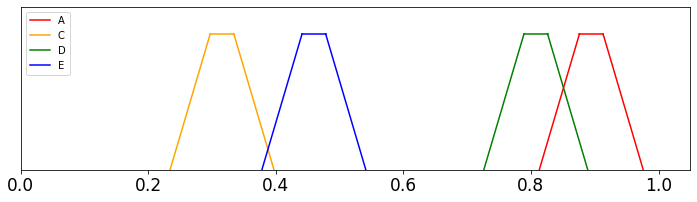

In [16]:
plt.figure(figsize=(12, 3))
plt.xlim(0, 1.05)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])

for i in range(len(result2)):
    company_name = result2.loc[i, '기업명']
    score = eval(result2.loc[i, '구간만족도'])
    score_with_spread = eval(result2.loc[i, '퍼지만족도'])
    plot_trape(score, score_with_spread[0::3], cols[i])

plt.legend(loc='upper left')   
plt.show()  